In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError

In [3]:
# load the dataset
data = pd.read_csv('/content/SDN_DDoS_.csv')
data.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,245230,44,40,124937,1071,9100,0,2839.477273,1839.508257,517,0,26.775000,109.188026,513835.99070,342.535579,2954.578313,7953.221927,64066,-44,238564,5548.000000,10446.29576,64066,2,245230,6287.948718,12986.46879,79070,29,0,0,880,804,179.423398,163.112180,0,9100,1482.447059,1933.268313,3.737526e+06,0,1,0,0,1,0,0,0,0,1500.095238,2839.477273,26.775000,44,124937,40,1071,41,0,0.0,0.0,0,0,0.0,0.0,0,0,0
1,1605449,107,149,1071,439537,517,0,10.009346,67.496680,27300,0,2949.912752,3012.589539,274445.34210,159.456949,6295.878431,56408.330520,859760,-102,1332121,12567.179250,83434.14155,861138,2,1603130,10831.959460,73926.65245,861129,1,0,0,2140,3004,66.648022,92.808928,0,27300,1714.428016,2713.465917,7.362897e+06,0,1,0,0,0,0,0,0,1,1721.125000,10.009346,2949.912752,107,1071,149,439537,4,0,0.0,0.0,0,0,0.0,0.0,0,0,0
2,53078,5,5,66,758,66,0,13.200000,29.516097,638,0,151.600000,276.826299,15524.32269,188.401975,5897.555556,15184.845200,46232,19,50302,12575.500000,22521.87727,46251,67,52962,13240.500000,22052.04405,46258,405,0,0,100,124,94.200987,94.200987,0,638,74.909091,190.807471,3.640749e+04,0,1,0,0,0,0,0,0,1,82.400000,13.200000,151.600000,5,66,5,758,1,0,0.0,0.0,0,0,0.0,0.0,0,0,0
3,6975,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.00000,286.738351,6975.000000,0.000000,6975,6975,0,0.000000,0.00000,0,0,0,0.000000,0.00000,0,0,0,0,20,20,143.369176,143.369176,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0.000000,1,0,1,0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0
4,190141,13,16,780,11085,427,0,60.000000,130.042942,2596,0,692.812500,794.157350,62401.06027,152.518394,6790.750000,12933.295910,38521,-54,86882,7240.166667,13050.84163,38805,1,190141,12676.066670,15949.09279,38521,1,0,0,260,344,68.370315,84.148080,0,2596,395.500000,661.691706,4.378359e+05,0,1,0,0,0,0,0,0,1,409.137931,60.000000,692.812500,13,780,16,11085,3,0,0.0,0.0,0,0,0.0,0.0,0,0,0


In [4]:
features = data.drop('Label', axis=1)
target = data['Label']

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 0].index
train_data = x_train.loc[train_index]

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [5]:
class AutoEncoder(Model):
  def __init__(self, output_units, code_size=16):
    super().__init__()
    self.encoder = Sequential([
      Dense(66, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(66, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='mse', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=64,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/100
856/856 [==============================] - 5s 4ms/step - loss: 0.0168 - accuracy: 0.5173 - val_loss: 0.0023 - val_accuracy: 0.6800
Epoch 2/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0024 - accuracy: 0.7378 - val_loss: 0.0018 - val_accuracy: 0.6672
Epoch 3/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0020 - accuracy: 0.7463 - val_loss: 0.0014 - val_accuracy: 0.6849
Epoch 4/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0017 - accuracy: 0.7655 - val_loss: 0.0013 - val_accuracy: 0.7137
Epoch 5/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0016 - accuracy: 0.7799 - val_loss: 0.0012 - val_accuracy: 0.7054
Epoch 6/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0015 - accuracy: 0.7888 - val_loss: 0.0012 - val_accuracy: 0.7431
Epoch 7/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0015 - accuracy: 0.8008 - val_loss: 0.0011 - val_accuracy: 0.7118

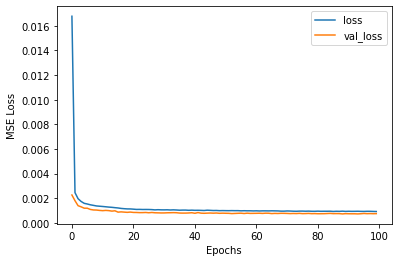

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [7]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

Threshold: 0.0019437121899367092


In [8]:
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(y_test,predictions)

0.8565040115743785

In [9]:
!pip install -U keras-tuner

     |████████████████████████████████| 98 kB 5.6 MB/s 


In [10]:
import kerastuner as kt

class AutoEncoderTuner(Model):

  def __init__(self, hp, output_units, code_size=8):
    super().__init__()
    dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
    dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
    dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
    dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
    dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
    dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)
    
    self.encoder = Sequential([
      Dense(dense_1_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_2_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_3_units, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(dense_4_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_5_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_6_units, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


def build_model(hp):
  model = AutoEncoderTuner(hp, 66)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      loss='msle',
      optimizer=Adam(learning_rate=hp_learning_rate),
  )
  return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [12]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    project_name='tuning_autoencoder6'
)

tuner.search(
    x_train_scaled, 
    x_train_scaled, 
    epochs=20, 
    batch_size=64,
    validation_data=(x_test_scaled, x_test_scaled)

)

Trial 31 Complete [00h 01m 23s]
val_loss: 0.008662069216370583

Best val_loss So Far: 0.00047473839367739856
Total elapsed time: 00h 16m 10s
INFO:tensorflow:Oracle triggered exit


In [13]:
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
  print(f"{hps}: {best_hyperparams[0][hps]}")

dense_1_units: 68
dense_2_units: 24
dense_3_units: 36
dense_4_units: 28
dense_5_units: 36
dense_6_units: 48
learning_rate: 0.001


In [14]:
best_model = tuner.get_best_models()[0]
best_model.compile(loss='mse',metrics=['accuracy'], optimizer=Adam(0.0001))

best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=64,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/100
856/856 [==============================] - 4s 4ms/step - loss: 0.0011 - accuracy: 0.8543 - val_loss: 8.5502e-04 - val_accuracy: 0.7852
Epoch 2/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0011 - accuracy: 0.8577 - val_loss: 8.4494e-04 - val_accuracy: 0.7850
Epoch 3/100
856/856 [==============================] - 3s 4ms/step - loss: 0.0011 - accuracy: 0.8588 - val_loss: 8.4537e-04 - val_accuracy: 0.7842
Epoch 4/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0011 - accuracy: 0.8610 - val_loss: 8.4610e-04 - val_accuracy: 0.7860
Epoch 5/100
856/856 [==============================] - 3s 4ms/step - loss: 0.0011 - accuracy: 0.8610 - val_loss: 8.3663e-04 - val_accuracy: 0.7848
Epoch 6/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0011 - accuracy: 0.8613 - val_loss: 8.3399e-04 - val_accuracy: 0.7867
Epoch 7/100
856/856 [==============================] - 3s 3ms/step - loss: 0.0011 - accuracy: 0.8619 - val_loss: 8.382

In [15]:
threshold_ = find_threshold(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
accuracy_score(preds_, y_test)

0.8567670656319873